In [2]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import joblib
from datetime import datetime

In [3]:
# 📂 Load the Dataset
df = pd.read_csv("employee_salary_prediction_dataset.csv")

# Scale salaries based on predefined tiers
# Features and target
X = df[['YearsExperience', 'EducationLevel', 'HoursWorkedPerWeek']]
y = df['MonthlySalary']

# Train a base model
scaler_model = LinearRegression()
scaler_model.fit(X, y)

# Predict salaries based on inputs
predicted_salary = scaler_model.predict(X)

# 🔁 Apply realistic scaling (e.g., multiply by 1000)
df['MonthlySalary'] = (predicted_salary * 1000).round(2)

df.head()

,YearsExperience,EducationLevel,HoursWorkedPerWeek,MonthlySalary
0,54.967142,34.630888,127.987109,195549.36
1,48.617357,39.547083,118.492674,161812.05
2,56.476885,23.007162,101.192607,196815.16
3,65.230299,32.814846,87.061264,188682.20
4,47.658466,26.746787,113.964466,178759.72


In [4]:
# Encode EducationLevel
df['EducationLevel'] = LabelEncoder().fit_transform(df['EducationLevel'])

# Features and target
X = df[['YearsExperience', 'EducationLevel', 'HoursWorkedPerWeek']]
y = df['MonthlySalary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for SVR
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, _, _ = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [9]:
# 📌 Results Dictionary
results = {}
model_preds= {}

### 1. Linear Regression

In [10]:
# === 1. Linear Regression ===
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
results['Linear Regression'] = {
    'MAE': mean_absolute_error(y_test, lr_pred),
    'R2': r2_score(y_test, lr_pred),
    'RMSE': mean_squared_error(y_test, lr_pred) ** 0.5  # manually take square root
}
model_preds['Linear Regression'] = lr_pred


### 2. Polynomial Regression

In [11]:
# === 2. Polynomial Regression ===
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_poly)
poly_pred = poly_model.predict(X_test_poly)
results['Polynomial Regression'] = {
    'MAE': mean_absolute_error(y_test_poly, poly_pred),
    'R2': r2_score(y_test_poly, poly_pred),
    'RMSE': mean_squared_error(y_test_poly, poly_pred) ** 0.5
}
model_preds['Polynomial Regression'] = poly_pred

### 3. XGBoost + GridSearchCV

In [12]:
# === 3. XGBoost + GridSearchCV ===
xgbr = xgb.XGBRegressor(random_state=42)
xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
xgb_grid = GridSearchCV(xgbr, xgb_params, cv=3)
xgb_grid.fit(X_train, y_train)
xgb_pred = xgb_grid.predict(X_test)
results['XGBoost'] = {
    'Best Params': xgb_grid.best_params_,
    'MAE': mean_absolute_error(y_test, xgb_pred),
    'R2': r2_score(y_test, xgb_pred),
    'RMSE': mean_squared_error(y_test, xgb_pred) **0.5
}
model_preds['XGBoost'] = xgb_pred

### 4. SVR + GridSearchCV

In [13]:
# === 4. SVR + GridSearchCV ===
svr = SVR()
svr_params = {'C': [1, 10], 'kernel': ['rbf', 'linear']}
svr_grid = GridSearchCV(svr, svr_params, cv=3)
svr_grid.fit(X_train_scaled, y_train)
svr_pred = svr_grid.predict(X_test_scaled)
results['SVR'] = {
    'Best Params': svr_grid.best_params_,
    'MAE': mean_absolute_error(y_test, svr_pred),
    'R2': r2_score(y_test, svr_pred),
    'RMSE': mean_squared_error(y_test, svr_pred) ** 0.5
}
model_preds['SVR'] = svr_pred

### 5. Gradient Boosting

In [14]:
# === 6. Gradient Boosting Regressor ===
from sklearn.ensemble import GradientBoostingRegressor
gbr_params = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gbr_params, cv=3)
gbr_grid.fit(X_train, y_train)
gbr_pred = gbr_grid.predict(X_test)
results['Gradient Boosting'] = {
    'Best Params': gbr_grid.best_params_,
    'MAE': mean_absolute_error(y_test, gbr_pred),
    'R2': r2_score(y_test, gbr_pred),
    'RMSE': mean_squared_error(y_test, gbr_pred) ** 0.5
}
model_preds['Gradient Boosting'] = gbr_pred

### Print All Results

In [15]:
# 📋 Summary Table
summary_df = pd.DataFrame.from_dict(results, orient='index')
summary_df = summary_df[['MAE', 'R2']]  # Only if you want selected metrics
print("\n📊 Model Summary:")
print(summary_df)



📊 Model Summary:
                                MAE        R2
Linear Regression       1444.506772  0.995870
Polynomial Regression   1502.476083  0.995440
XGBoost                 3959.426619  0.950066
SVR                    23543.605018  0.172395
Gradient Boosting       3655.602046  0.959152


###  Plot: Actual vs Predicted (Best Model)

In [16]:
import os
os.makedirs("plots", exist_ok=True)


🏆 Best Model Based on R²: Linear Regression


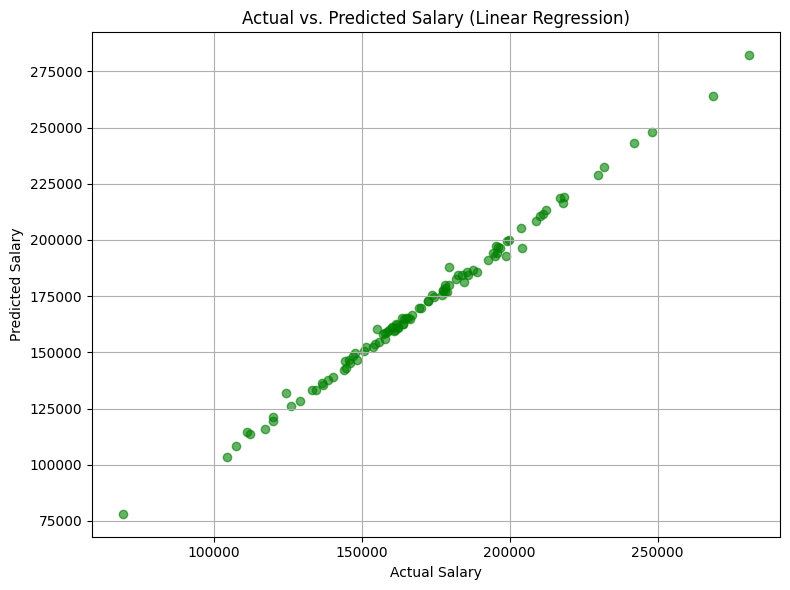

In [17]:
# 📊 Best Model Plot
best_model_name = max(results.items(), key=lambda x: x[1]['R2'])[0]
print(f"\n🏆 Best Model Based on R²: {best_model_name}")

model_preds = {
    'Linear Regression': lr_pred,
    'Polynomial Regression': poly_pred,
    'XGBoost': xgb_pred,
    'SVR': svr_pred,
    'Gradient Boosting': gbr_pred
}
best_pred = model_preds[best_model_name]

plt.figure(figsize=(8,6))
plt.scatter(y_test, best_pred, alpha=0.6, c='green')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title(f"Actual vs. Predicted Salary ({best_model_name})")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"plots/{best_model_name}_actual_vs_predicted.png")
plt.show()


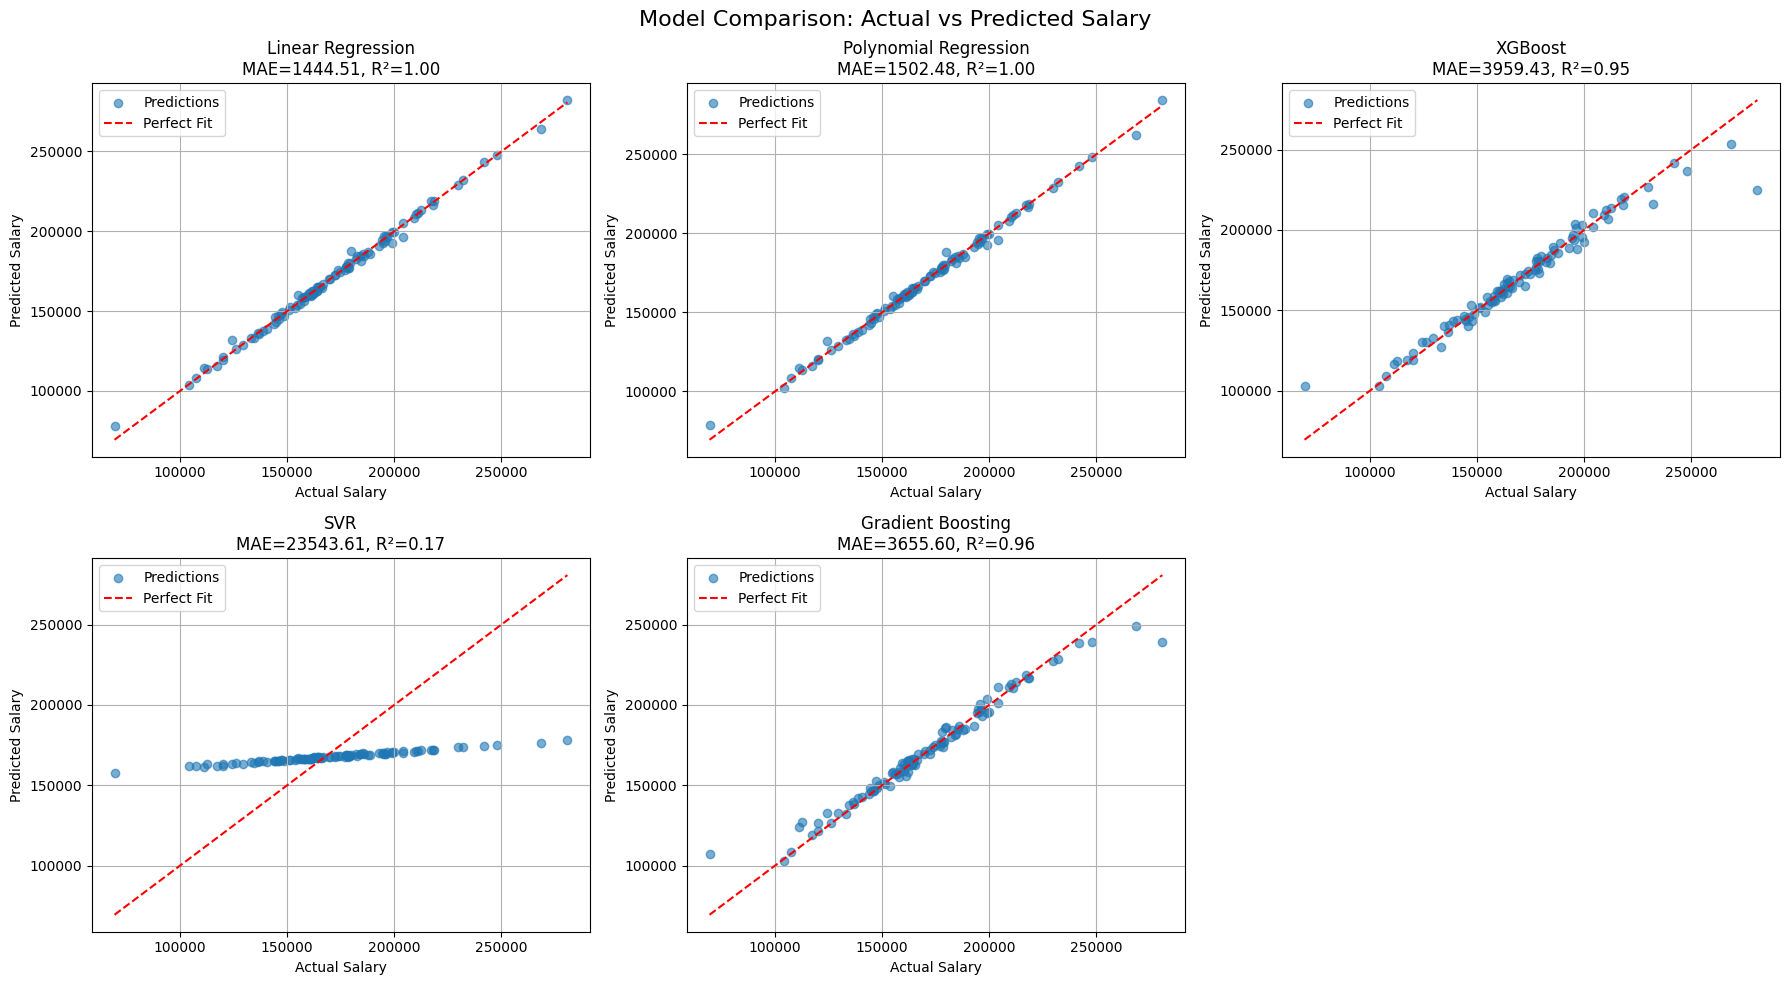

In [18]:
# 📊 Model Comparison Subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

model_names = list(model_preds.keys())
predictions = list(model_preds.values())

for i in range(len(model_names)):
    mae = results[model_names[i]]['MAE']
    r2 = results[model_names[i]]['R2']

    axes[i].scatter(y_test, predictions[i], alpha=0.6, label='Predictions')
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                 'r--', label='Perfect Fit')  # Diagonal line

    axes[i].set_title(f"{model_names[i]}\nMAE={mae:.2f}, R²={r2:.2f}")
    axes[i].set_xlabel("Actual Salary")
    axes[i].set_ylabel("Predicted Salary")
    axes[i].legend()
    axes[i].grid(True)

# Hide unused axes if any
for j in range(len(model_names), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Model Comparison: Actual vs Predicted Salary", fontsize=16)
plt.tight_layout()
plt.savefig("plots/model_comparison.png")
plt.show()


In [19]:
best_model = {
    'Linear Regression': lr_model,
    'Polynomial Regression': poly_model,
    'XGBoost': xgb_grid.best_estimator_,
    'SVR': svr_grid.best_estimator_,
    'Gradient Boosting': gbr_grid.best_estimator_
}[best_model_name]

joblib.dump(best_model, "best_model.pkl")
print("✅ Best model saved as best_model.pkl")

✅ Best model saved as best_model.pkl


In [20]:
# 📅 Save Performance Report
with open("model_performance.txt", "w", encoding="utf-8") as f:
    f.write(f"📅 Report Generated: {datetime.now()}\n")
    for model, metrics in results.items():
        f.write(f"\n🔹 {model} Results:\n")
        for k, v in metrics.items():
            f.write(f"  {k}: {v}\n")

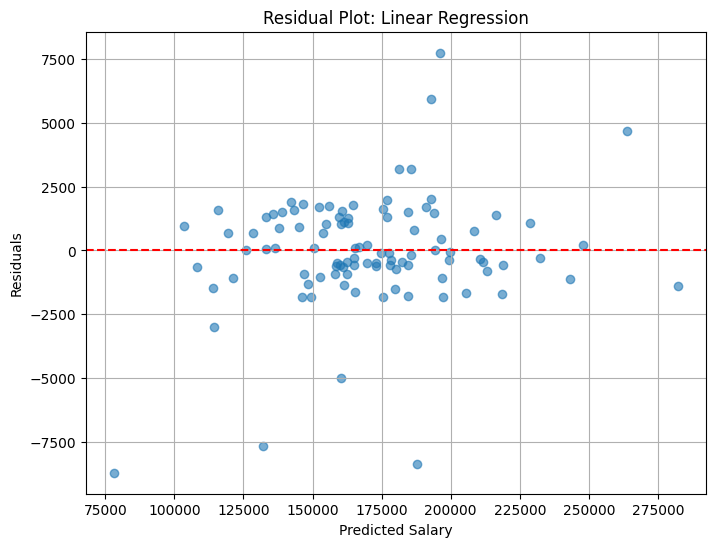

In [21]:
# 🔍 Residual Plot for Best Model
residuals = y_test - best_pred
plt.figure(figsize=(8, 6))
plt.scatter(best_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residual Plot: {best_model_name}")
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

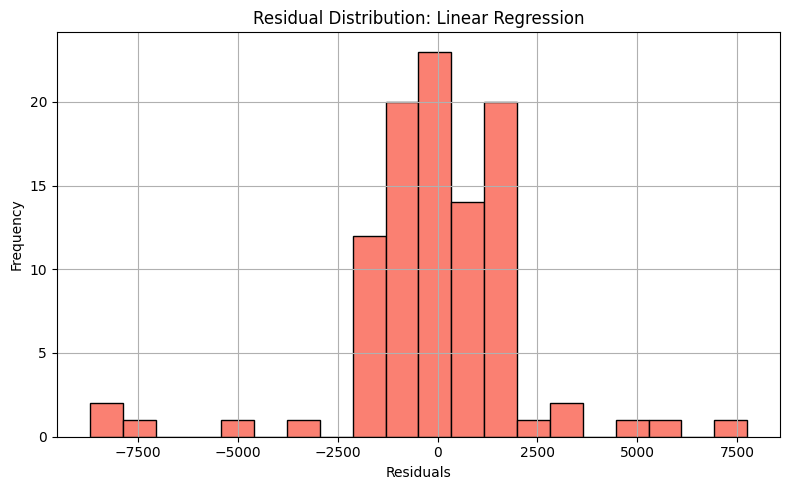

In [22]:
# 📊 Residual Histogram
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, color='salmon', edgecolor='black')
plt.title(f"Residual Distribution: {best_model_name}")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

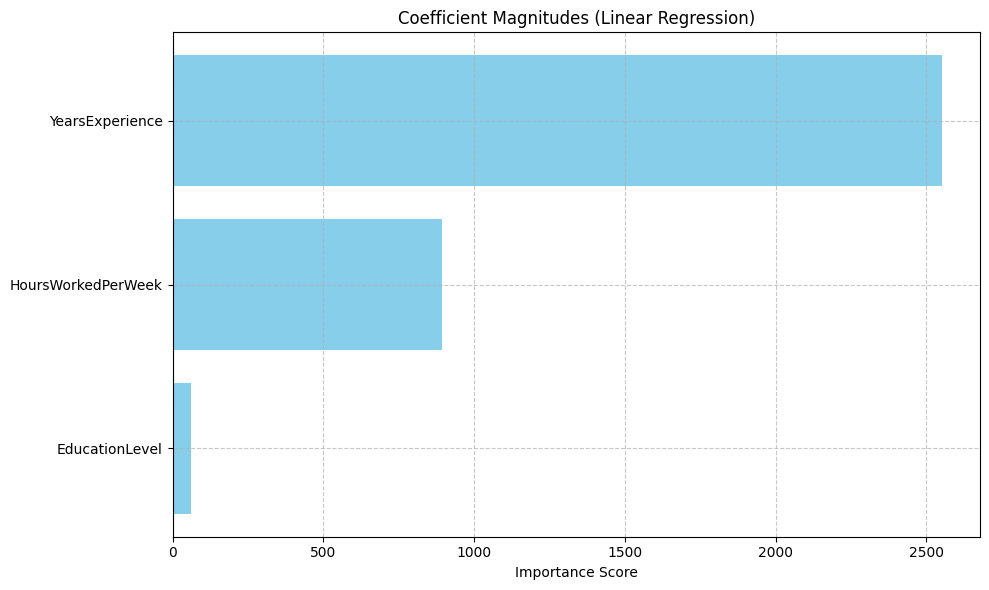

In [23]:
# ✨ Feature Importance (All Supported Models)
importances = None
labels = X.columns

title = None
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    title = f"Feature Importance: {best_model_name}"

elif best_model_name == "Linear Regression" and hasattr(best_model, "coef_"):
    importances = np.abs(best_model.coef_)
    title = "Coefficient Magnitudes (Linear Regression)"

elif best_model_name == "Polynomial Regression" and hasattr(poly_model, "coef_"):
    importances = np.abs(poly_model.coef_)
    title = "Polynomial Regression Coefficient Magnitudes"
    labels = poly.get_feature_names_out(X.columns)

if importances is not None:
    sorted_idx = np.argsort(importances)

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(labels)[sorted_idx], importances[sorted_idx], color="skyblue")
    plt.title(title)
    plt.xlabel("Importance Score")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Feature importance not supported for this model.")

In [24]:
# 🔎 Permutation Importance using eli5 (only for scikit-learn models)
import eli5
from eli5.sklearn import PermutationImportance

if best_model_name in ['Linear Regression', 'Polynomial Regression', 'SVR']:
    perm = PermutationImportance(best_model, random_state=42).fit(X_test, y_test)
    eli5.show_weights(perm, feature_names=X.columns.tolist())
else:
    print("⚠️ eli5 only works reliably with linear or scikit-learn compatible models.")

c:\Users\ALOK\Desktop\SmartPay AI-Powered Employee Salary Prediction System\env\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


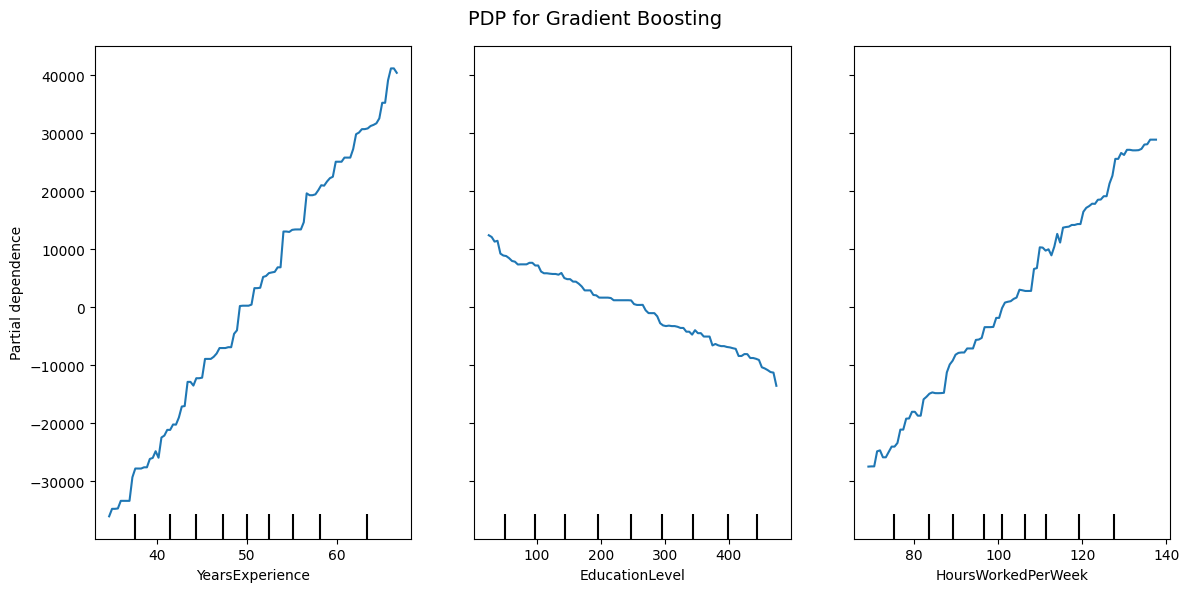

In [25]:
from sklearn.inspection import PartialDependenceDisplay

# Force PDP for Gradient Boosting even if it's not the best
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(gbr_grid.best_estimator_, X_train, features=[0, 1, 2], feature_names=X.columns, ax=ax)
plt.suptitle(f"PDP for Gradient Boosting", fontsize=14)
plt.tight_layout()
fig.savefig("plots/gradient_boosting_pdp.png")
plt.show()
